<a href="https://colab.research.google.com/github/Timure228/LSTM_Based_Text_Generator/blob/main/LSTM_Text_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Text Generator

In [2]:
import torch
from torch import nn
from torch.nn import RNN, LSTM, Dropout

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import regex
import string

import numpy as np

In [3]:
FILE = "lstb.txt"
with open(FILE, "r") as f:
  lines_amount = f.read().count("\n") + 1

lines_amount

7841

In [4]:
translator = str.maketrans('', '', string.punctuation)

In [31]:
import re

with open(FILE, "r") as f:
  text = f.read()
  text = text.strip().translate(translator).lower()
  text = text[:int(len(text)*0.6) + 4]
  print(text.count("\n") + 1)

# print(f"Before: {len(text)}")

# text = re.sub('\)', '',text)
# text = re.sub('\(', '',text)

# for pattern in set(re.findall('<unk>', text)):
#   text = re.sub(pattern, '', text)

# print(f"After: {len(text)}")

4717


In [32]:
train_text = text[:int(len(text)*0.8)]
test_text = text[int(len(text)*0.8):]

In [33]:
# Tokenize
tokens = []
for i in text.split():
  for j in i.split():
    tokens.append(j)

most_common = max(set(tokens), key=tokens.count)

print(f"Word \"{most_common}\" appears: {tokens.count(most_common)} times.")
print(tokens.count("the"))

tokens = list(set(tokens))
vocab_size = len(tokens)
tokens[:10], vocab_size

Word "the" appears: 2110 times.
2110


(['awaited',
  'crooked',
  'sick',
  'absolutely',
  'motioned',
  'heard',
  'knot',
  'daughter',
  'comfortable',
  'glimmering'],
 5029)

In [34]:
indx_to_token = {indx: token for indx, token in enumerate(tokens)}
token_to_indx = {token: indx for indx, token in enumerate(tokens)}

In [26]:
# Create encode and decode function
def encode(arr: list, token_to_indx=token_to_indx):
  for i in arr:
    for j in range(len(i)):
      i[j] = token_to_indx[i[j]]
  return arr

def decode(arr: list, indx_to_token=indx_to_token):
  for i in arr:
    for j in range(len(i)):
      i[j] = indx_to_token[i[j]]
  return arr

In [27]:
SEQ_LENGTH = 10

def create_sequence(X: list, y: list, text: str, SEQ_LENGTH = SEQ_LENGTH, STEP=1):
  text_arr = text.split()
  for i in range(0, len(text_arr)- SEQ_LENGTH, STEP):
    X.append(text_arr[i:i + SEQ_LENGTH])
    y.append([text_arr[i+SEQ_LENGTH]])
  return X, y

In [35]:
# Creating the sequences
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

X_test[1], y_test[1]

(['his',
  'head',
  'sadly',
  'come',
  'watson',
  'said',
  'he',
  'our',
  'ways',
  'lie'],
 ['elsewhere'])

In [36]:
# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

In [15]:
X_test = encode(X_test)
y_test = encode(y_test)

In [37]:
# Padding X
X_train_padded = pad_sequences(X_train, maxlen=10, padding='post', value=0)  # 'post' means pad at the end of each sequence

# X_test_padded = pad_sequences(X_test, maxlen=10, padding='post', value=0)

In [38]:
print(f"X Shape: {X_train_padded.shape}")

X Shape: (32518, 10)


In [39]:
# Converting X and y to categorical vectors
X_train_cat = to_categorical(X_train_padded, num_classes=vocab_size)
y_train_cat = to_categorical(y_train, num_classes=vocab_size)

In [ ]:
X_test_cat = to_categorical(X_test_padded, num_classes=vocab_size)
y_test_cat = to_categorical(y_test, num_classes=vocab_size)

In [20]:
# Check the ranks of X and y
print(f"X Rank: {tf.rank(X_train_cat)} | y Rank: {tf.rank(y_train_cat)}")
print(f"X Shape: {X_train_cat.shape} | y shape: {y_train_cat.shape}")
print(f"X Type: {type(X_train_cat)} | y Type: {type(y_train_cat)}")

X Rank: 3 | y Rank: 2
X Shape: (10818, 10, 2658) | y shape: (10818, 2658)
X Type: <class 'numpy.ndarray'> | y Type: <class 'numpy.ndarray'>


In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

# TensorFlow Based

In [41]:
model = Sequential()
model.add(keras.layers.Input(shape=(SEQ_LENGTH, vocab_size)))
model.add(Dropout(rate=0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_cat, y_train_cat, epochs=10, verbose=1)

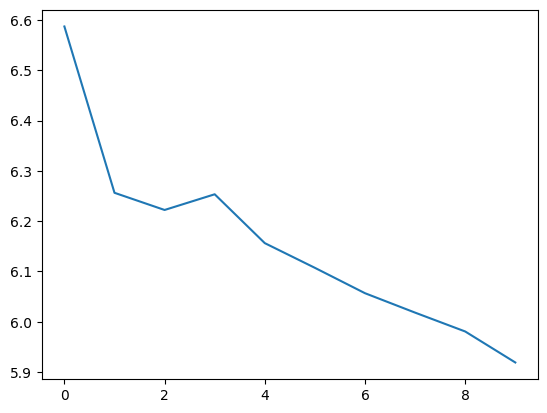

In [31]:
# Plot the Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["loss"])

In [32]:
# Model structure
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)                  │ (None, 10, 2658)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 10, 128)             │       1,426,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2658)                │         172,770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,959,848 (18.92 MB)

 Trainable params: 1,653,282 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,306,566 (12.61 MB)

In [44]:
input_string = [["why", "would", "you", "do", "that", "for", "things", "you", "do", "it"]]

def convert(string):
  input_string_arr = [token_to_indx[i] for i in input_string[0]]
  input_string_arr = pad_sequences([input_string_arr], maxlen=10, padding="pre", value=0)
  input_string_arr = tf.keras.utils.to_categorical(input_string_arr, num_classes=vocab_size)
  return input_string_arr

input_string_arr = convert(input_string)

y_preds = model.predict(input_string_arr)
print(y_preds)

probabilities = tf.argmax(y_preds, axis=1)
print(probabilities)
input_string[0].append(indx_to_token[int(probabilities)])
print(input_string)
print(" ".join(input_string[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[[1.9678791e-04 1.3731580e-03 1.7210376e-06 ... 2.9231215e-04
  4.7177979e-05 8.6732049e-05]]
tf.Tensor([550], shape=(1,), dtype=int64)
[['why', 'would', 'you', 'do', 'that', 'for', 'things', 'you', 'do', 'it', 'the']]
why would you do that for things you do it the


In [37]:
loop_string = [["who", "those", "people", "are", "so", "difficult", "about", "their", "money", "and"]]
arr_input = convert(loop_string)

def predict_loop(string_input, arr_input, output_length):
  for i in range(output_length):
    print(i)
    y_preds = model.predict(arr_input)
    probabilities = tf.argmax(tf.nn.softmax(y_preds), axis=1)
    string_input[0].append(indx_to_token[int(probabilities)])
    new_string = string_input[0][i + 1:]
    print(new_string)
    arr_input = convert(new_string)


In [38]:
predict_loop(loop_string, arr_input, 10)

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
['those', 'people', 'are', 'so', 'difficult', 'about', 'their', 'money', 'and', 'the']
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
['people', 'are', 'so', 'difficult', 'about', 'their', 'money', 'and', 'the', 'the']
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
['are', 'so', 'difficult', 'about', 'their', 'money', 'and', 'the', 'the', 'the']
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
['so', 'difficult', 'about', 'their', 'money', 'and', 'the', 'the', 'the', 'the']
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
['difficult', 'about', 'their', 'money', 'and', 'the', 'the', 'the', 'the', 'the']
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
['about', 'their', 'money', 'and', 'the', 'the', 'the', 'the', 'the', 'the']
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
['their', 'money', 'and', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
['money', 'and', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/s

In [ ]:
# Evaluating the model
model.evaluate(X_test_cat, y_test_cat)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9001 - loss: 0.6876


[0.680959165096283, 0.9000769853591919]

In [ ]:
model.save("model_0.keras")

# PyTorch Based

In [ ]:
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

In [ ]:
X_test = encode(X_test)
y_test = encode(y_test)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.long).reshape(len(X_train), SEQ_LENGTH) / vocab_size
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.long).reshape(len(X_test), SEQ_LENGTH) / vocab_size
y_test = torch.tensor(y_test, dtype=torch.long)

<ipython-input-207-d66e4a4b863e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long).reshape(len(X_train), SEQ_LENGTH) / vocab_size
<ipython-input-207-d66e4a4b863e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
<ipython-input-207-d66e4a4b863e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.long).reshape(len(X_test), SEQ_LENGTH) / vocab_size
<ipython-input-207-d66e4a4b863e>:5: UserWarning: To copy 

In [ ]:
class Model0(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(Model0, self).__init__()
    self.layer_dim = layer_dim
    self.hidden_dim = hidden_dim

    self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim,
                     batch_first=True)
    self.linear = torch.nn.Linear(hidden_dim, output_dim)
    self.softMax = torch.nn.Softmax()

  def forward(self, x, h0=None, c0=None):
    if h0 is None and c0 is None:
      h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
      c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

    out, (hn, hc) = self.lstm(x, (h0, c0))
    out = self.linear(out[:, -1, :])
    return out, hn, hc

In [ ]:
class Model1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, dropout=0.2)
    self.dropout = nn.Dropout(0.2)
    self.linear = nn.Linear(128, output_size)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.linear(x)
    return x

In [ ]:
model1 = Model1(input_size=10, hidden_size=128, output_size=vocab_size)
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

In [ ]:
from torch.utils import data

batch_size = 128

train_dataset_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
# test_dataset_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=batch_size)

In [ ]:
for x, y in train_dataset_loader:
  print(x.shape)

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size

https://machinelearningmastery.com/text-generation-with-lstm-in-pytorch/

In [ ]:
## Training loop for model 1
EPOCHS = 500

for epoch in range(EPOCHS):
  model1.train()
  for X_train, y_train in train_dataset_loader:
    if len(X_train) != 128:
      continue

    y_pred = model1(X_train)

    loss = loss_fn(y_pred, y_train.squeeze(1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Validation
  model1.eval()
  loss = 0
  with torch.no_grad():
    for X_train, y_train in train_dataset_loader:
        y_pred = model1(X_train)
        loss += loss_fn(y_pred, y_train.squeeze(1))
    if (epoch + 1) % 100 == 0:
      print(f"Epoch: {epoch + 1} | Loss: {loss:.4f}")

Epoch: 100 | Loss: 555.4913
Epoch: 200 | Loss: 555.0812
Epoch: 300 | Loss: 554.6782
Epoch: 400 | Loss: 555.4270
Epoch: 500 | Loss: 555.5330


In [ ]:
custom_string = "why should i do this instead of the man who"
X_custom = [[]]

for i in custom_string.split():
  X_custom[0].append(i)

# Encoding, converting to numerical
X_custom = encode(X_custom)

In [ ]:
X_custom = torch.tensor(X_custom, dtype=torch.float32).reshape(len(X_custom), SEQ_LENGTH) / vocab_size

In [ ]:
indx_to_token[int(torch.argmax(model1(X_custom), dim=1))]

'one'

In [ ]:
def nuke(n):
  a = []
  for i in range(10):
    if n > 1:
      a.append(nuke(n-1))
    else:
      a.append(i)
  return a

# print(nuke(10))